In [2]:
import jax

# Get current default device
current_device = jax.devices()[0]
print(f"Current default device: {current_device}")

# Get all available devices
all_devices = jax.devices()
print(f"All available devices: {all_devices}")

# Check if GPU is available
gpu_available = any(d.platform == 'gpu' for d in jax.devices())
print(f"GPU available: {gpu_available}")

# You can also check device platform directly
platform = jax.devices()[0].platform
print(f"Platform: {platform}")  # Will show 'cpu', 'gpu', or 'tpu'

Current default device: TFRT_CPU_0
All available devices: [CpuDevice(id=0)]
GPU available: False
Platform: cpu


In [1]:
import sys
sys.path.append('..')

from tools.siren import *
from tools.table import *

from tools.simulation import create_siren_grid
from tools.generate import new_differentiable_get_rays

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
#import jax.numpy as jnp

def calculate_opening_angles(ray_vectors, direction):
    # Normalize the direction vector
    direction_norm = direction / jnp.linalg.norm(direction)
    
    # Normalize each ray vector
    # Using axis=1 since shape is (100000, 3)
    ray_vectors_norm = ray_vectors / jnp.linalg.norm(ray_vectors, axis=1)[:, None]
    
    # Calculate dot product between normalized vectors
    # This will give us cos(theta)
    cos_theta = jnp.dot(ray_vectors_norm, direction_norm)
    
    # Calculate opening angles in radians using arccos
    # Clip values to [-1, 1] to avoid numerical errors
    angles = jnp.arccos(jnp.clip(cos_theta, -1.0, 1.0))
    
    return angles

In [3]:
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10

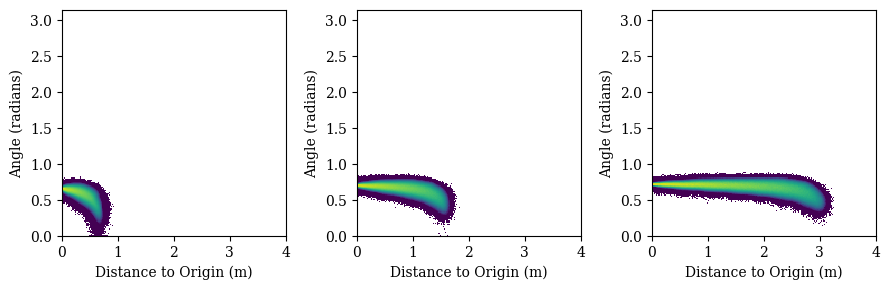

In [5]:
table = Table('cprof_mu_train_10000ev.h5')
table_data = create_siren_grid(table)
siren_model, model_params = load_siren_jax('siren_cprof_mu.pkl')
origin = jnp.array([0.5, 0.0, -0.5])
direction = jnp.array([1.0, -1.0, 0.2])
Nphot = 1000000
key = random.PRNGKey(0)

fig, axes = plt.subplots(1,3, figsize=(9,3))

energies = [300, 500, 800]

for i, energy in enumerate(energies):

    ray_vectors, ray_origins, photon_weights = new_differentiable_get_rays(origin, direction, energy, Nphot, table_data, model_params, key)
    
    ranges = jnp.linalg.norm(ray_origins-origin, axis=1)
    angles = calculate_opening_angles(ray_vectors, direction)
    
    h = axes[i].hist2d(ranges, angles, 
                  weights=photon_weights.squeeze(), 
                  bins=[200, 200], 
                  cmap='viridis',
                  norm=LogNorm(vmin=2),
                  range=[[0,4], [0,3.14]])

    axes[i].set_ylabel('Angle (radians)')
    axes[i].set_xlabel('Distance to Origin (m)')

fig.patch.set_facecolor('white')
fig.tight_layout()
plt.show()